# Simple Fully Connected Autoencoder
This example demonstrate how to create and use a simple fully connected autoencoder for anomaly detection on data streams. The example uses the `CreditCard` dataset from the river library and shows how the module integrates into the river ecosystem.

In [1]:
from river import compose, preprocessing, metrics, datasets
from deep_river.anomaly import AutoencoderInitialized
from torch import nn, manual_seed
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skrub import TableReport

/Users/cedrickulbach/Documents/Environments/deep-river/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


## Analyse
This code initializes a reproducible environment and loads a subset of the CreditCard dataset, selecting 5000 transactions for analysis. It then converts the dataset into a Pandas DataFrame and generates a summary report using TableReport(), which provides an overview of the dataset's structure, feature distributions, and potential missing values. This step helps to understand the data before applying preprocessing or modeling techniques.

In [2]:
_ = manual_seed(42)
dataset = datasets.CreditCard().take(5000)
TableReport(pd.DataFrame([x for x, _ in dataset]))

Processing column  30 / 30


,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


## Model Creation
This block sets up an anomaly detection pipeline using an autoencoder-based neural network. It begins by loading a subset of the CreditCard dataset and defining a rolling ROC AUC metric to evaluate model performance dynamically over a window of 5000 samples. The `MyAutoEncoder` class constructs a simple autoencoder with a bottleneck layer of configurable dimensionality (`latent_dim=3`), using LeakyReLU activation for encoding and a sigmoid function for reconstruction. A pipeline is then created, consisting of a `MinMaxScaler` for feature normalization and the autoencoder wrapped within `AutoencoderInitialized`, optimizing it with a learning rate of 0.005. This setup enables online learning, where the model updates continuously as new data arrives.

In [11]:
dataset = datasets.CreditCard().take(5000)
metric = metrics.RollingROCAUC(window_size=5000)
class MyAutoEncoder(nn.Module):
    def __init__(self, n_features, latent_dim=3):
        super(MyAutoEncoder, self).__init__()
        self.linear1 = nn.Linear(n_features, latent_dim)
        self.nonlin = nn.LeakyReLU()
        self.linear2 = nn.Linear(latent_dim, n_features)
        self.sigmoid = nn.Sigmoid()

    def forward(self, X, **kwargs):
        X = self.linear1(X)
        X = self.nonlin(X)
        X = self.linear2(X)
        return self.sigmoid(X)


model_pipeline = compose.Pipeline(
    preprocessing.MinMaxScaler(), 
    AutoencoderInitialized(module=MyAutoEncoder(30), lr=0.005)
)
model_pipeline

Pipeline (
  MinMaxScaler (),
  AutoencoderInitialized (
    module=MyAutoEncoder(
    (linear1): Linear(in_features=30, out_features=3, bias=True)
    (nonlin): LeakyReLU(negative_slope=0.01)
    (linear2): Linear(in_features=3, out_features=30, bias=True)
    (sigmoid): Sigmoid()
  )
    loss_fn="mse"
    optimizer_fn="sgd"
    lr=0.005
    is_feature_incremental=False
    device="cpu"
    seed=42
  )
)

## Run the Datastream
This block performs hyperparameter optimization by evaluating the impact of different latent dimensions on the model's performance. It iterates over a predefined set of `latent_dim` values, initializing a fresh dataset and rolling ROC AUC metric for each experiment. A pipeline is created for each latent dimension, consisting of a `MinMaxScaler` for normalization and an autoencoder trained using online learning. The model is then trained and evaluated sequentially on the dataset, updating the metric with its predictions. After processing all data points, the final ROC AUC score is recorded for the current latent dimension. Once all experiments are completed, the results are stored in a DataFrame and visualized using a line plot, where the x-axis represents the latent dimension values and the y-axis represents the corresponding ROC AUC scores. This visualization helps identify the optimal latent dimension for anomaly detection.

In [12]:
for x, y in dataset:
    score = model_pipeline.score_one(x)
    metric.update(y_true=y, y_pred=score)
    model_pipeline.learn_one(x=x)
print(f"ROCAUC: {metric.get():.4f}")

ROCAUC: 0.8901


## Hyperparameter Optimization
This block processes the dataset sequentially, evaluating and updating the model in an online learning manner. For each data point, the model generates an anomaly score using `score_one(x)`, which is then used to update the rolling ROC AUC metric by comparing it to the true label `y`. After scoring, the model is trained incrementally using `learn_one(x)`, allowing it to adapt continuously as new data arrives. Once all data points have been processed, the final ROC AUC score is printed, providing a performance measure of the model's ability to distinguish between fraudulent and non-fraudulent transactions.

In [13]:
latent_dims = [2, 5, 10, 20, 30, 40]  # You can adjust this range
results = []

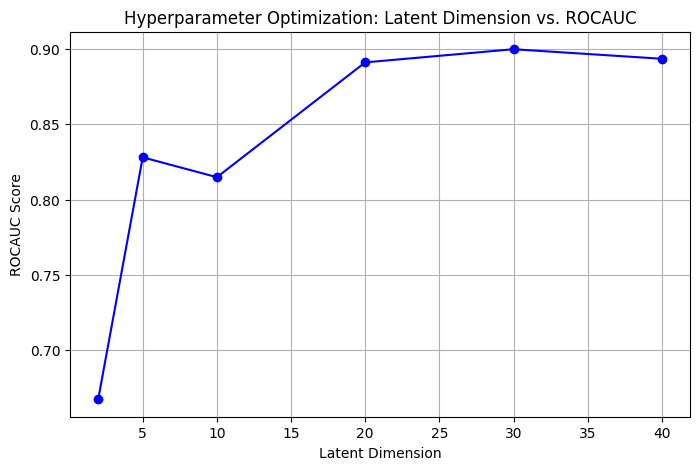

In [14]:
for latent_dim in latent_dims:
    # Initialize a fresh metric
    dataset = datasets.CreditCard().take(5000)
    metric = metrics.RollingROCAUC(window_size=5000)

    # Initialize pipeline with current latent_dim
    model_pipeline = compose.Pipeline(
        preprocessing.MinMaxScaler(),
        AutoencoderInitialized(module=MyAutoEncoder(30, latent_dim), lr=0.005)
    )

    # Train and evaluate model
    for x, y in dataset:
        score = model_pipeline.score_one(x)
        metric.update(y_true=y, y_pred=score)
        model_pipeline.learn_one(x=x)

    # Store the result
    results.append((latent_dim, metric.get()))

# Convert results to DataFrame for visualization
df_results = pd.DataFrame(results, columns=["latent_dim", "ROCAUC"])

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(df_results["latent_dim"], df_results["ROCAUC"], marker="o", linestyle="-", color="b")
plt.xlabel("Latent Dimension")
plt.ylabel("ROCAUC Score")
plt.title("Hyperparameter Optimization: Latent Dimension vs. ROCAUC")
plt.grid(True)
plt.show()